In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
import os, re, glob2, pickle
from PIL import Image
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
image_path = 'C:/Users/bilal/OneDrive/Desktop/morphs1' # addres of images

In [3]:
no_of_images = 20 # number of images. It is recommended to use a square of 2 number
ellipside =False # elipsoid or rectangular visualization
image_width = 64 # width and height of each visualized images

In [4]:
feature_extraction = 'vggfaces'

In [5]:
image_names  = glob2.glob(image_path + "**/*.png") 
image_names +=glob2.glob(image_path + "**/*.jpg")
image_names +=glob2.glob(image_path + "**/*.gif")
# suffle images
np.random.seed(3)
np.random.shuffle(image_names)
if no_of_images > len(image_names):
    no_of_images = len(image_names)
image_names = image_names[:no_of_images]

In [6]:
if feature_extraction == 'vggfaces':
    print('using %s network/method for feature extraction'%feature_extraction)
    # Convolution Features
    features = np.zeros([no_of_images, 2048])
    vgg_model_conv = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
    
    vgg_model = VGGFace() # pooling: None, avg or max
    out = vgg_model.get_layer('fc7').output
    vgg_model_fc7 = Model(vgg_model.input, out)
    
    feature_filename = '%s-feature-vggfaces-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 4096])
        for i, name in enumerate(image_names):
            img = image.load_img(name, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x)
            print('image name: %s progress: %d/%d'%(name, i, no_of_images))
            features[i, :] = vgg_model_fc7.predict(x)
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)


using vggfaces network/method for feature extraction


In [7]:
tsne = TSNE()
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

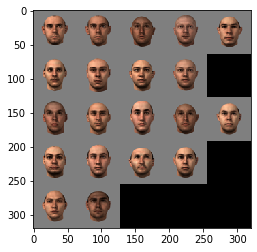

(20, 15)


<Figure size 8640x8640 with 0 Axes>

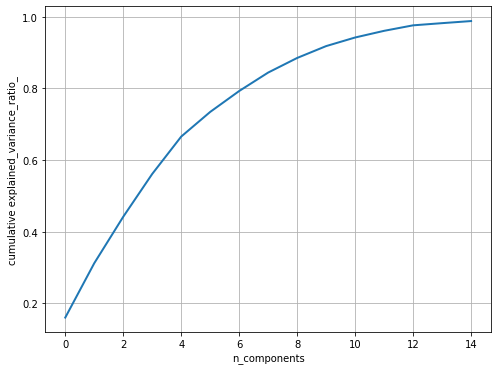

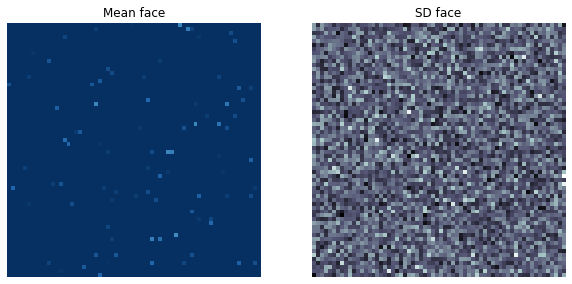

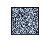

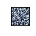

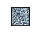

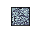

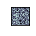

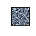

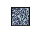

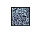

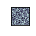

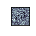

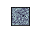

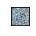

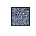

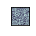

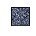

<Figure size 360x144 with 0 Axes>

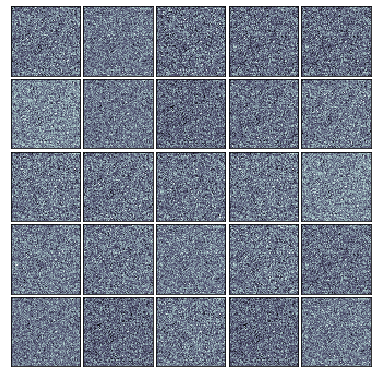

In [10]:
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()

fig = plt.figure(figsize=(120,120)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot 15 random faces
# j = 1
# np.random.seed(0)
# for i in np.random.choice(range(img.shape[0]), 10): 
#     ax = fig.add_subplot(5, 6, j, xticks=[], yticks=[]) 
#     ax.imshow(img[i,:], cmap='gray',aspect='auto') 
#     j += 1
# plt.show()


n_comp =15
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_comp))])
faces_proj = pipeline.fit_transform(features)

print(faces_proj.shape)
# (400, 64)
mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (64,64))
sd_face = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (64,64))
pylab.figure(figsize=(8, 6))
pylab.plot(np.cumsum(pipeline.named_steps['pca'].explained_variance_ratio_), linewidth=2)
pylab.grid(), pylab.axis('tight'), pylab.xlabel('n_components'), pylab.ylabel('cumulative explained_variance_ratio_')
pylab.show()
pylab.figure(figsize=(10,5))
pylab.subplot(121), pylab.imshow(mean_face, cmap='RdBu_r',vmin=1,vmax =64), pylab.axis('off'), pylab.title('Mean face')
pylab.subplot(122), pylab.imshow(sd_face, cmap=pylab.cm.bone), pylab.axis('off'), pylab.title('SD face')
pylab.show()

fig = plt.figure(figsize=(5,2)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the first 10 eigenfaces
for i in range(15): 
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(pipeline.named_steps['pca'].components_[i,:], (64,64)), cmap=plt.cm.bone, interpolation='nearest')
    
    fig = plt.figure(figsize=(5,2)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

# face reconstruction
faces_inv_proj = pipeline.named_steps['pca'].inverse_transform(faces_proj) 
#reshaping as 400 images of 64x64 dimension 
fig = plt.figure(figsize=(5,5)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 dimension but 8x8 pixels 
j = 1
np.random.seed(0)
for i in np.random.choice(range(features.shape[0]), 25): 
    ax = fig.add_subplot(5, 5, j, xticks=[], yticks=[]) 
    ax.imshow(mean_face + sd_face*np.reshape(faces_inv_proj,(20,64,64)) [i,:], cmap=plt.cm.bone, interpolation='nearest')
    j += 1